# 1 Preparation


In [3]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1Data

In [4]:
import pandas as pd
import numpy as np
np.random.seed(12345)
# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/Dataset/crypto_data.csv')
data.head()


,Unnamed: 0,date,close,total_volume,market_cap,name
0,9895,2015-01-01 00:00:00.000,313.992,4.699936e+07,4.293958e+09,bitcoin
1,9896,2015-01-02 00:00:00.000,314.446,3.885591e+07,4.301448e+09,bitcoin
2,9897,2015-01-03 00:00:00.000,286.572,1.187789e+08,3.921358e+09,bitcoin
3,9898,2015-01-04 00:00:00.000,260.936,2.055001e+08,3.571640e+09,bitcoin
4,9899,2015-01-05 00:00:00.000,273.220,1.550381e+08,3.740880e+09,bitcoin


In [5]:
# Convert the "date" column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Format the "date" column to retain only year, month, and day
data['date'] = data['date'].dt.strftime('%Y-%m-%d')

# Set the "date" column as the index
data.set_index('date', inplace=True)

# Calculate the log return for each cryptocurrency in the new dataset
data['log_return'] = data.groupby('name')['close'].transform(lambda x: np.log(x / x.shift(1)))

# Standardize the log return
data['log_return'] = data.groupby('name')['log_return'].transform(lambda x: (x - x.mean()) / x.std())

# Calculate the 30-day realized volatility for each cryptocurrency in the new dataset
data['volatility_7day'] = data.groupby('name')['log_return'].transform(lambda x: x.rolling(window=7).std())
data['volatility_30day'] = data.groupby('name')['log_return'].transform(lambda x: x.rolling(window=30).std())


# bipower variation and Jumps
data['BV'] = data.groupby('name')['log_return'].transform(lambda x: abs(x * x.shift(1)))
data['squared_return'] = data.groupby('name')['log_return'].transform(lambda x: x**2)
data['Jump'] = data['squared_return'] - data['BV']

# lag components
data['lag1'] = data['volatility_30day'].shift(1)
data['lag7'] = data['volatility_30day'].shift(7)
data['lag30'] = data['volatility_30day'].shift(30)



# Filter out data before 2015-09-16 because some time series start from 2015-08-15
data = data[data.index > '2015-10-01']
data = data.iloc[:-120]
test_size = 240

data.drop(columns=['Unnamed: 0'], inplace=True)
# Display the data with the new 30-day volatility column
data.head()


,close,total_volume,market_cap,name,log_return,volatility_7day,volatility_30day,BV,squared_return,Jump,lag1,lag7,lag30
date,,,,,,,,,,,,,
2015-10-02,237.2593,8.444875e+07,3.482919e+09,bitcoin,-0.090723,0.329507,0.341216,0.013578,0.008231,-0.005348,0.341732,0.376926,0.865761
2015-10-03,238.9718,7.335304e+07,3.508907e+09,bitcoin,0.151244,0.331441,0.338384,0.013721,0.022875,0.009153,0.341216,0.372881,0.862372
2015-10-04,238.6566,7.889957e+07,3.505203e+09,bitcoin,-0.072664,0.315840,0.331922,0.010990,0.005280,-0.005710,0.338384,0.327780,0.869172
2015-10-05,240.3238,1.074344e+08,3.530597e+09,bitcoin,0.145182,0.170823,0.319702,0.010550,0.021078,0.010528,0.331922,0.344884,0.878206
2015-10-06,246.4440,1.357767e+08,3.621402e+09,bitcoin,0.623580,0.264474,0.329944,0.090532,0.388852,0.298320,0.319702,0.348001,0.885209


In [6]:
data.drop(['total_volume', 'market_cap'], axis=1, inplace = True)
mean_value = data['lag30'].mean()
data['lag30'].fillna(mean_value, inplace=True)
data.isna().sum()

close               0
name                0
log_return          0
volatility_7day     0
volatility_30day    0
BV                  0
squared_return      0
Jump                0
lag1                0
lag7                0
lag30               0
dtype: int64

## 1.2 Observe the data

### Test for Persistence

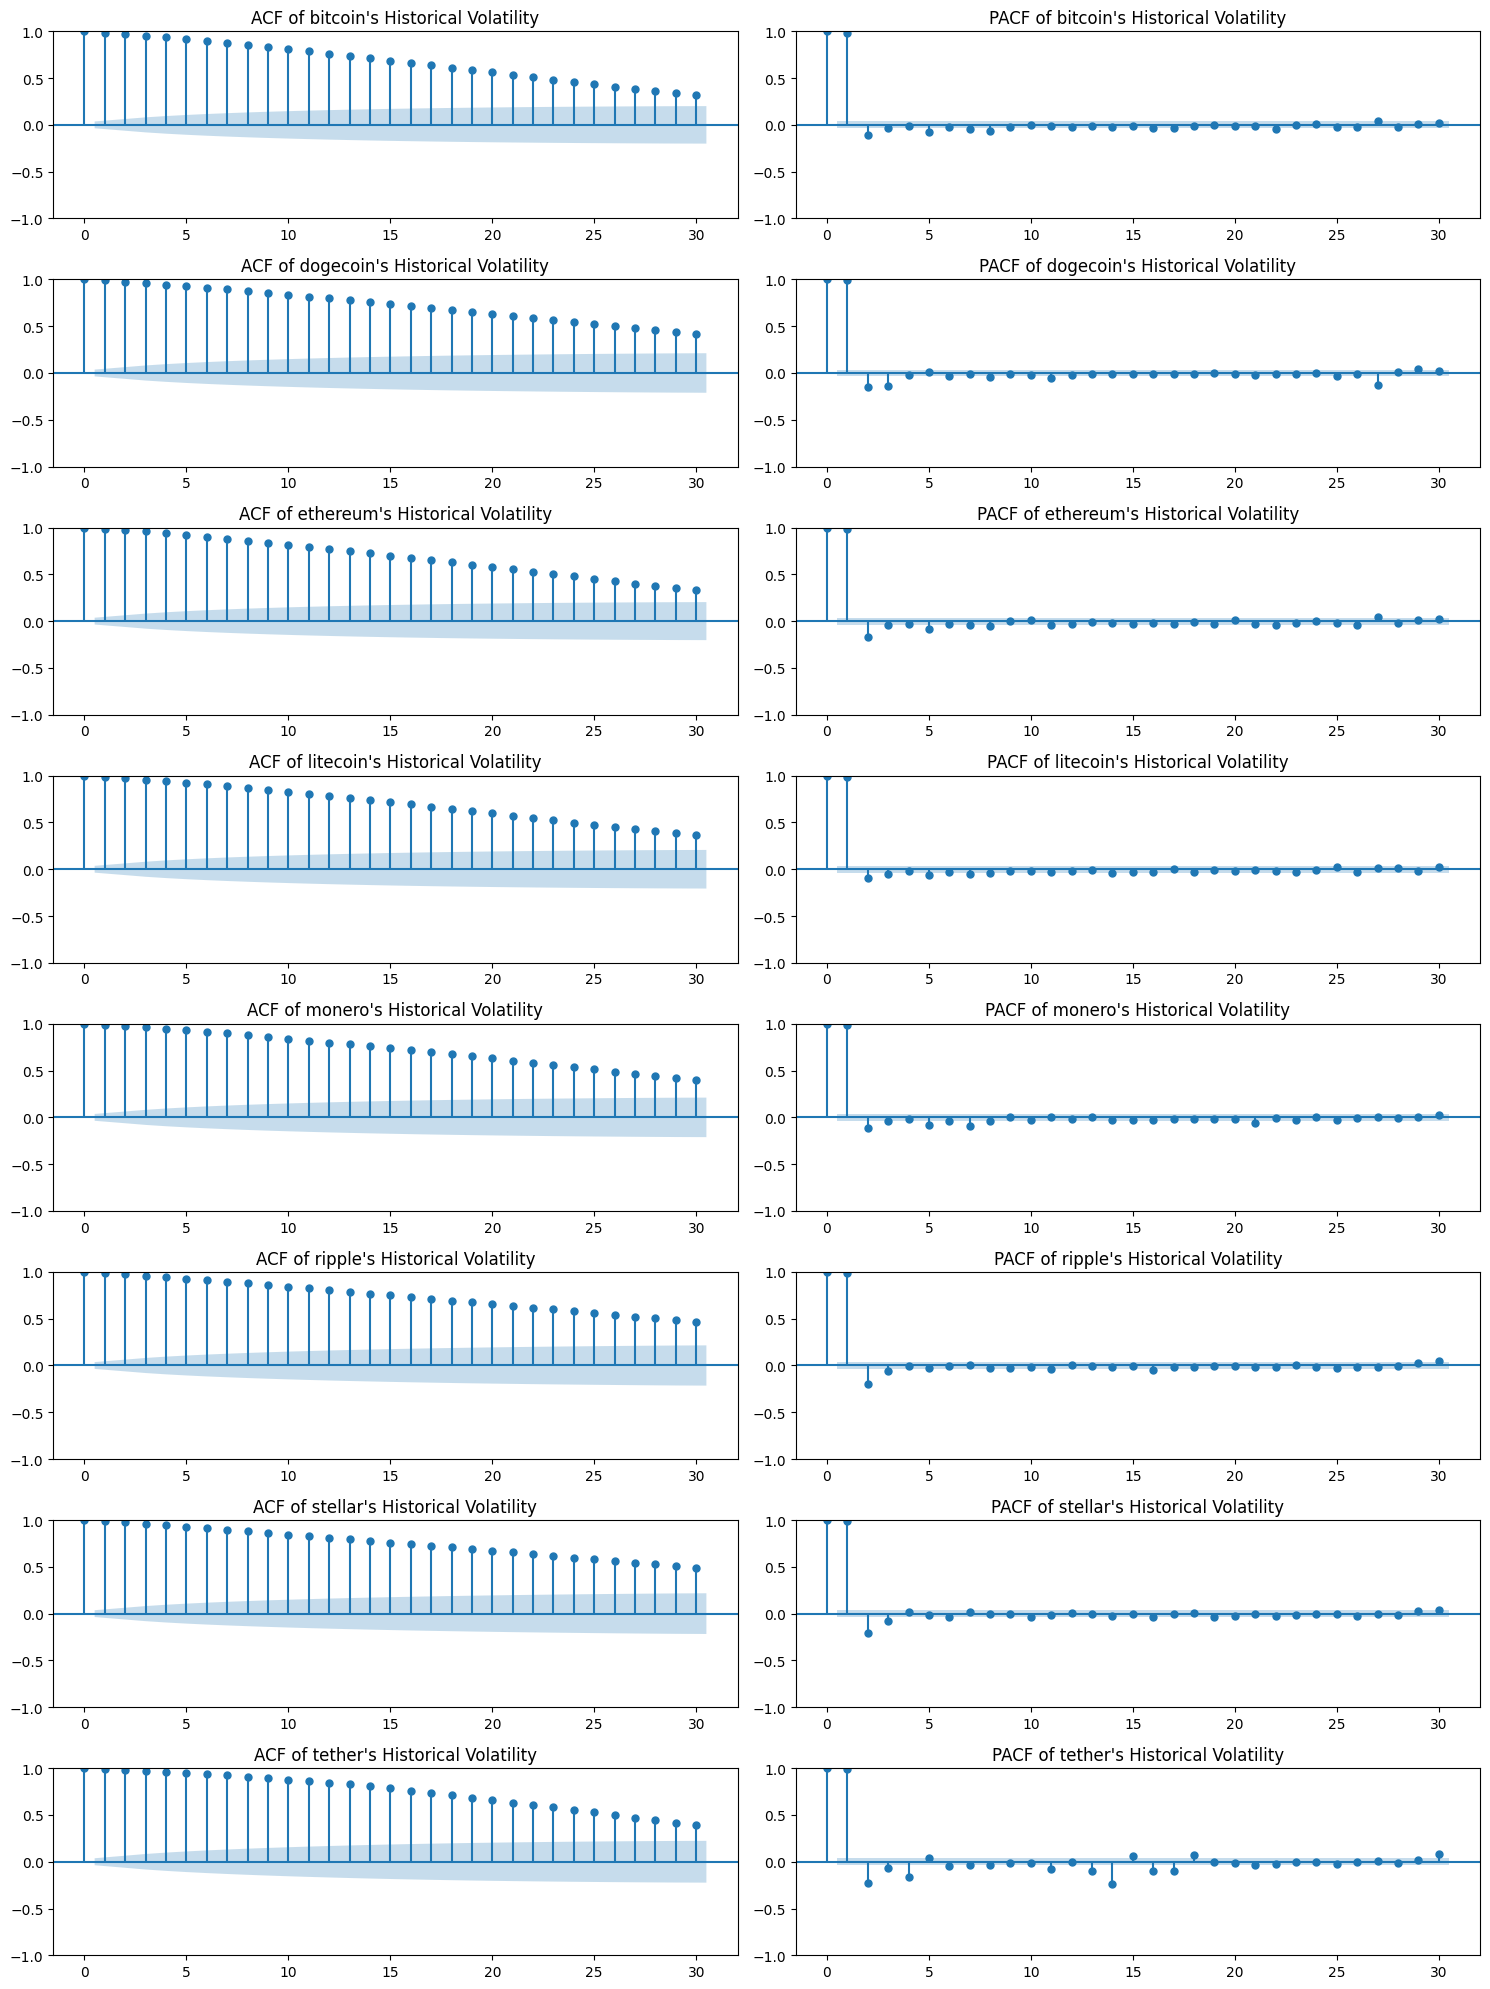

In [8]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Get unique coin names from the new dataset
coin_names = data['name'].unique()

# Plot ACF and PACF for each cryptocurrency in the new dataset
plt.figure(figsize=(15, 20))

for index, coin in enumerate(coin_names, 1):
    coin_data = data[data['name'] == coin]['volatility_30day'].dropna()

    # ACF plot
    plt.subplot(len(coin_names), 2, 2*index - 1)
    sm.graphics.tsa.plot_acf(coin_data, lags=30, ax=plt.gca(), title=f"ACF of {coin}'s Historical Volatility")

    # PACF plot
    plt.subplot(len(coin_names), 2, 2*index)
    sm.graphics.tsa.plot_pacf(coin_data, lags=30, ax=plt.gca(), title=f"PACF of {coin}'s Historical Volatility")

plt.tight_layout()
plt.show()


### Test for Mean Reversion

In [6]:
from statsmodels.tsa.stattools import adfuller

# Function to conduct ADF test
def adf_test(series):
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1]  # Return p-value

# Apply the ADF test on the 30-day realized volatility for each cryptocurrency
adf_p_values = data.groupby('name')['volatility_30day'].apply(adf_test)

adf_p_values


name
bitcoin     1.476300e-07
dogecoin    5.165175e-09
ethereum    1.497182e-09
litecoin    1.105482e-06
monero      1.435993e-06
ripple      1.750765e-05
stellar     2.331268e-05
tether      2.495760e-11
Name: volatility_30day, dtype: float64

### Test for Asymmetry

In [7]:
import statsmodels.formula.api as smf

# Function to conduct regression analysis for asymmetry
def test_asymmetry(dt):
    dt['lagged_return'] = dt['log_return'].shift(1)
    model = smf.ols(formula='volatility_30day ~ lagged_return', data=dt).fit()
    return model.params['lagged_return'], model.pvalues['lagged_return']

# Apply the regression analysis for each cryptocurrency
asymmetry_results = data.groupby('name').apply(test_asymmetry)

# Extract coefficients and p-values
asymmetry_coefficients = asymmetry_results.apply(lambda x: x[0])
asymmetry_pvalues = asymmetry_results.apply(lambda x: x[1])

asymmetry_coefficients, asymmetry_pvalues


(name
 bitcoin    -0.007031
 dogecoin    0.055229
 ethereum    0.007474
 litecoin    0.011269
 monero      0.008248
 ripple      0.038272
 stellar     0.044173
 tether     -0.035072
 dtype: float64,
 name
 bitcoin     0.354225
 dogecoin    0.000001
 ethereum    0.315334
 litecoin    0.160039
 monero      0.321374
 ripple      0.000196
 stellar     0.000003
 tether      0.043622
 dtype: float64)

 ### Test for Heavy Tails

In [8]:
from scipy.stats import jarque_bera

# Function to conduct Jarque-Bera test
def test_heavy_tails(series):
    result = jarque_bera(series.dropna())
    return result[1]  # Return p-value

# Apply the Jarque-Bera test on the log returns for each cryptocurrency
jb_p_values = data.groupby('name')['log_return'].apply(test_heavy_tails)

jb_p_values


name
bitcoin     0.0
dogecoin    0.0
ethereum    0.0
litecoin    0.0
monero      0.0
ripple      0.0
stellar     0.0
tether      0.0
Name: log_return, dtype: float64

### Summary

In [9]:
# Create a DataFrame to summarize the results
summary_df = pd.DataFrame({
    'Cryptocurrency': coin_names,
    'ADF Test p-value': adf_p_values.values,
    'Asymmetry Coefficient': asymmetry_coefficients.values,
    'Asymmetry p-value': asymmetry_pvalues.values,
    'Jarque-Bera Test p-value': jb_p_values.values
})

# Set Cryptocurrency as the index
summary_df.set_index('Cryptocurrency', inplace=True)
summary_df



,ADF Test p-value,Asymmetry Coefficient,Asymmetry p-value,Jarque-Bera Test p-value
Cryptocurrency,,,,
bitcoin,1.476300e-07,-0.007031,0.354225,0.0
dogecoin,5.165175e-09,0.055229,0.000001,0.0
ethereum,1.497182e-09,0.007474,0.315334,0.0
litecoin,1.105482e-06,0.011269,0.160039,0.0
monero,1.435993e-06,0.008248,0.321374,0.0
ripple,1.750765e-05,0.038272,0.000196,0.0
stellar,2.331268e-05,0.044173,0.000003,0.0
tether,2.495760e-11,-0.035072,0.043622,0.0


# 2 Fitting Models

In [10]:
# Split the data for each cryptocurrency
train_data = {}
test_data = {}

for crypto in data['name'].unique():
    crypto_data = data[data['name'] == crypto]

    # Calculate the split index based on the desired test size
    split_idx = len(crypto_data) - test_size

    train_data[crypto] = crypto_data.iloc[:split_idx]
    test_data[crypto] = crypto_data.iloc[split_idx:]

# Display the number of observations in training and testing sets for each cryptocurrency
train_test_counts = [(crypto, len(train_data[crypto]), len(test_data[crypto])) for crypto in train_data.keys()]
train_test_counts_df = pd.DataFrame(train_test_counts, columns=["Cryptocurrency", "Training Set", "Testing Set"])
train_test_counts_df

,Cryptocurrency,Training Set,Testing Set
0,bitcoin,2635,240
1,dogecoin,2635,240
2,ethereum,2635,240
3,litecoin,2635,240
4,monero,2634,240
5,ripple,2635,240
6,stellar,2630,240
7,tether,2501,240


In [11]:
# Out-of-Sample Performance Metrics
def compute_out_of_sample_metrics(forecasted, actual):
    forecasted = np.array(forecasted)  # Convert forecasted to a numpy array

    me = np.mean(forecasted - actual)
    mse = np.mean((forecasted - actual) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(forecasted - actual))
    mape = np.mean(np.abs((forecasted - actual) / actual))

    # Extreme values metrics
    extreme_mask = actual > 1.28 * np.std(actual)
    extreme_forecasted = forecasted[extreme_mask]
    extreme_actual = actual[extreme_mask]

    extreme_me = np.mean(extreme_forecasted - extreme_actual)
    extreme_mse = np.mean((extreme_forecasted - extreme_actual) ** 2)
    extreme_rmse = np.sqrt(extreme_mse)
    extreme_mae = np.mean(np.abs(extreme_forecasted - extreme_actual))
    extreme_mape = np.mean(np.abs((extreme_forecasted - extreme_actual) / extreme_actual))

    return {
        "ME": me, "RMSE": rmse, "MAE": mae, "MAPE": mape,
        "Extreme_ME": extreme_me, "Extreme_RMSE": extreme_rmse,
        "Extreme_MAE": extreme_mae, "Extreme_MAPE": extreme_mape
    }


In [12]:
# In-Sample Performance Metrics
def extract_in_sample_metrics(model_result):
    # Extract residuals and fitted values
    residuals = model_result.resid
    y_true = model_result.model.endog
    y_pred = model_result.predict()

    # Compute variance of the residuals
    sigma2 = residuals.var()

    # Compute the log-likelihood
    n = len(residuals)
    logL = (-n/2) * np.log(2 * np.pi) - (n/2) * np.log(sigma2) - (1/(2 * sigma2)) * np.sum((y_true - y_pred) ** 2)

    # Number of predictors (excluding intercept)
    k = len(model_result.params) - 1

    # AIC and BIC
    aic = -2*logL + 2*(k+1)
    bic = -2*logL + np.log(n)*(k+1)

    return {
        "AIC": aic,
        "BIC": bic,
        "Log-Likelihood": logL
    }

def extract_arch_in_sample_metrics(model_result):
    # Extract residuals
    residuals = model_result.resid
    fitted = residuals

    # Compute variance of the residuals
    sigma2 = residuals.var()

    # Compute the log-likelihood
    n = len(residuals)
    logL = (-n/2) * np.log(2 * np.pi) - (n/2) * np.log(sigma2) - (1/(2 * sigma2)) * np.sum(residuals ** 2)

    # Number of predictors (excluding intercept)
    k = len(model_result.params) - 1

    # AIC and BIC
    aic = -2*logL + 2*(k+1)
    bic = -2*logL + np.log(n)*(k+1)

    return {
        "AIC": aic,
        "BIC": bic,
        "Log-Likelihood": logL
    }

## 2.1 GARCH

In [13]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 916.4/916.4 kB 7.4 MB/s eta 0:00:00


### 2.1.1 Basic GARCH

In [ ]:
# fitting the models
from arch import arch_model

# fitting GARCH
def fit_garch(data, p=1, q=1):
    model = arch_model(data['log_return'], vol='Garch', p=p, q=q)
    return model.fit()

garch_results = {crypto: fit_garch(train_data[crypto]) for crypto in train_data.keys()}

# Initialize data structures to hold metrics for all cryptocurrencies
garch_out_of_sample = []
garch_in_sample = []
garch_in_sample_forecasts = {}
garch_out_of_sample_forecasts = {}

# making forecast
for crypto in train_data.keys():
    # Forecast the next 30-day changes in `volatility_30day` using the GARCH model
    actual_volatility = test_data[crypto]['volatility_30day'].values
    garch_forecasts = np.sqrt(garch_results[crypto].forecast(start=0, horizon=len(test_data[crypto])).variance.values[-1])

    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(garch_forecasts, actual_volatility)
    garch_out_of_sample.append(out_of_sample_metrics)

    # Extract in-sample metrics
    in_sample_metrics = extract_arch_in_sample_metrics(garch_results[crypto])
    garch_in_sample.append(in_sample_metrics)

    # Get the in-sample forecasts (fitted values)
    in_sample_forecast = garch_results[crypto].conditional_volatility

    # Generate the out-of-sample forecasts for the length of the test data
    out_of_sample_forecast = np.sqrt(garch_results[crypto].forecast(start=0, horizon=len(test_data[crypto])).variance.values[-1, :])

    # Store the forecasts in the dictionaries
    garch_in_sample_forecasts[crypto] = in_sample_forecast
    garch_out_of_sample_forecasts[crypto] = out_of_sample_forecast

# Convert the dictionaries to DataFrames
df_garch_in_sample_forecasts = pd.DataFrame(garch_in_sample_forecasts)
df_garch_out_of_sample_forecasts = pd.DataFrame(garch_out_of_sample_forecasts)


# Convert metrics to DataFrames and standardize
df_out_of_sample = pd.DataFrame(garch_out_of_sample, index=train_data.keys())
df_in_sample = pd.DataFrame(garch_in_sample, index=train_data.keys())
garch_average_out_of_sample = df_out_of_sample.mean()
garch_average_in_sample = df_in_sample.mean()


In [64]:
# Merging the GARCH metrics dictionaries
merged_dict = {**garch_average_out_of_sample, **garch_average_in_sample}

# Convert merged dictionary into a DataFrame
df_merged = pd.DataFrame([merged_dict], index=["GARCH"])
df_merged

,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.725579,0.763653,0.727739,2.566556,0.651008,0.694961,0.657995,1.856004,6987.788288,7011.267606,-3489.894144


### 2.1.2 GJR-GARCH

In [96]:
# fitting GJR-GARCH
def fit_gjrgarch(data, p=1, q=1, o=1):
    model = arch_model(data['log_return'], vol='GARCH', p=p, o=o, q=q)
    return model.fit()

gjrgarch_results = {crypto: fit_gjrgarch(train_data[crypto]) for crypto in train_data.keys()}

# Initialize data structures to hold metrics for all cryptocurrencies
gjrgarch_out_of_sample = []
gjrgarch_in_sample = []
gjrgarch_out_of_sample_forecasts = {}


# making forecast
for crypto in train_data.keys():
    # Forecast the next 30-day changes in `volatility_30day`
    actual_volatility = test_data[crypto]['volatility_30day'].values
    gjrgarch_forecasts = np.sqrt(gjrgarch_results[crypto].forecast(start=0, horizon=len(test_data[crypto])).variance.values[-1])

    gjrgarch_out_of_sample_forecasts[crypto] = gjrgarch_forecasts
    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(gjrgarch_forecasts, actual_volatility)
    gjrgarch_out_of_sample.append(out_of_sample_metrics)

    # Extract in-sample metrics
    in_sample_metrics = extract_arch_in_sample_metrics(gjrgarch_results[crypto])
    gjrgarch_in_sample.append(in_sample_metrics)

# Convert metrics to DataFrames and standardize
df_out_of_sample = pd.DataFrame(gjrgarch_out_of_sample, index=train_data.keys())
df_in_sample = pd.DataFrame(gjrgarch_in_sample, index=train_data.keys())
gjrgarch_average_out_of_sample = df_out_of_sample.mean()
gjrgarch_average_in_sample = df_in_sample.mean()



Iteration:      1,   Func. Count:      7,   Neg. LLF: 38579.795782146044
Iteration:      2,   Func. Count:     17,   Neg. LLF: 8951.522825010727
Iteration:      3,   Func. Count:     25,   Neg. LLF: 4910.60142951061
Iteration:      4,   Func. Count:     33,   Neg. LLF: 4120.6520276595165
Iteration:      5,   Func. Count:     40,   Neg. LLF: 3646.447471848993
Iteration:      6,   Func. Count:     47,   Neg. LLF: 3660.48693205529
Iteration:      7,   Func. Count:     54,   Neg. LLF: 3637.7335675022055
Iteration:      8,   Func. Count:     61,   Neg. LLF: 3623.8021019754274
Iteration:      9,   Func. Count:     68,   Neg. LLF: 3623.5987654747437
Iteration:     10,   Func. Count:     74,   Neg. LLF: 3623.5974136996506
Iteration:     11,   Func. Count:     80,   Neg. LLF: 3623.597371418594
Iteration:     12,   Func. Count:     86,   Neg. LLF: 3623.5973647788114
Iteration:     13,   Func. Count:     91,   Neg. LLF: 3623.5973647788414
Optimization terminated successfully    (Exit mode 0)
    

/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/usr/local/lib/python3.10/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alter

In [17]:
# Merging the GJRGARCH metrics dictionaries
gjrgarch_merged_dict = {**gjrgarch_average_out_of_sample, **gjrgarch_average_in_sample}

# Convert the merged dictionary into a DataFrame
df_gjrgarch = pd.DataFrame([gjrgarch_merged_dict], index=["GJR-GARCH"])

# Append GJRGARCH results to the existing DataFrame
metrics_summary = df_merged.append(df_gjrgarch)
metrics_summary

<ipython-input-17-5c4f1d3c34ea>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = df_merged.append(df_gjrgarch)


,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.725579,0.763653,0.727739,2.566556,0.651008,0.694961,0.657995,1.856004,6987.788288,7011.267606,-3489.894144
GJR-GARCH,0.944695,0.998787,0.949712,3.078236,0.857723,0.925130,0.873908,2.403954,6989.027181,7018.376329,-3489.513590


### 2.1.3 FIGARCH

In [ ]:
# fitting FIGARCH
def fit_figarch(data, p=1, q=1):
    model = arch_model(data['log_return'], vol='FIGARCH', p=p, q=q)
    return model.fit()

figarch_results = {crypto: fit_figarch(train_data[crypto]) for crypto in train_data.keys()}

# Initialize data structures to hold metrics for all cryptocurrencies
figarch_out_of_sample = []
figarch_in_sample = []
figarch_out_of_sample_forecasts = {}

# making forecast
for crypto in train_data.keys():
    # Forecast the next 30-day changes in `volatility_30day`
    actual_volatility = test_data[crypto]['volatility_30day'].values
    figarch_forecasts = np.sqrt(figarch_results[crypto].forecast(start=0, horizon=len(test_data[crypto])).variance.values[-1])

    figarch_out_of_sample_forecasts[crypto] = figarch_forecasts
    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(figarch_forecasts, actual_volatility)
    figarch_out_of_sample.append(out_of_sample_metrics)

    # Extract in-sample metrics
    in_sample_metrics = extract_arch_in_sample_metrics(figarch_results[crypto])
    figarch_in_sample.append(in_sample_metrics)

# Convert metrics to DataFrames and standardize
df_out_of_sample = pd.DataFrame(figarch_out_of_sample, index=train_data.keys())
df_in_sample = pd.DataFrame(figarch_in_sample, index=train_data.keys())
figarch_average_out_of_sample = df_out_of_sample.mean()
figarch_average_in_sample = df_in_sample.mean()


In [19]:
# Merging the FIGARCH metrics dictionaries
figarch_merged_dict = {**figarch_average_out_of_sample, **figarch_average_in_sample}

# Convert the merged dictionary into a DataFrame
df_figarch = pd.DataFrame([figarch_merged_dict], index=["FIGARCH"])

# Append FIGARCH results to the existing DataFrame
metrics_summary = metrics_summary.append(df_figarch)


<ipython-input-19-4a7c94340ca7>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(df_figarch)


,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.725579,0.763653,0.727739,2.566556,0.651008,0.694961,0.657995,1.856004,6987.788288,7011.267606,-3489.894144
GJR-GARCH,0.944695,0.998787,0.949712,3.078236,0.857723,0.925130,0.873908,2.403954,6989.027181,7018.376329,-3489.513590
FIGARCH,0.642547,0.683895,0.649275,2.244421,0.553459,0.613380,0.575281,1.709230,6989.702213,7019.051361,-3489.851106


## 2.2 HAR

In [20]:
import statsmodels.api as sm

### 2.2.1 Basic HAR

In [67]:
# fitting HAR
def prepare_har_data(data):
    data['lagV30'] = data['lag1']
    data['lagV7'] = data['volatility_7day'].shift(1)
    data['lagV1'] = data['log_return'].shift(1)
    return data.dropna()

def fit_har(data):
    prepared_data = prepare_har_data(data)
    model = sm.OLS(prepared_data['volatility_30day'], sm.add_constant(prepared_data[['lagV1', 'lagV7', 'lagV30']]))
    return model.fit()

def forecast_har(data, model_result, forecast_horizon):
    forecasts = []
    for i in range(forecast_horizon):
        # Prepare the features for the next prediction
        lagV1 = data['lagV1'].iloc[-1] if i == 0 else forecasts[i-1]
        lagV7 = data['lagV7'].iloc[-7 + i] if i < 7 else forecasts[i-7]
        lagV30 = data['lagV30'].iloc[-30 + i] if i < 30 else forecasts[i-30]

        # Predict the next volatility
        next_forecast = model_result.params['const'] + model_result.params['lagV1'] * lagV1 + model_result.params['lagV7'] * lagV7 + model_result.params['lagV30'] * lagV30

        forecasts.append(next_forecast)

    return forecasts

# Initialize data structures to hold metrics for all cryptocurrencies
har_out_of_sample = []
har_in_sample = []
har_forecasts = {}
har_results = {}
har_forecasts_dict = {}
har_out_of_sample_forecasts = pd.DataFrame()

for crypto in train_data.keys():
    actual_volatility = test_data[crypto]['volatility_30day'].values

# Forecast and calculate metrics for each cryptocurrency
for crypto in train_data.keys():
    prepared_data = train_data[crypto]
    actual_volatility = test_data[crypto]['volatility_30day'].values
    har_results[crypto] = fit_har(prepared_data)
    har_forecasts = forecast_har(prepared_data, har_results[crypto], len(test_data[crypto]))
    df_forecast = pd.DataFrame(har_forecasts, columns=[crypto])
    har_out_of_sample_forecasts = pd.concat([har_out_of_sample_forecasts, df_forecast], axis=1)


    har_forecasts_dict[crypto] = har_forecasts
    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(har_forecasts, actual_volatility)
    har_out_of_sample.append(out_of_sample_metrics)

    # Extract in-sample metrics
    in_sample_metrics = extract_arch_in_sample_metrics(har_results[crypto])
    har_in_sample.append(in_sample_metrics)

# Convert metrics to DataFrames and standardize
df_out_of_sample = pd.DataFrame(har_out_of_sample, index=train_data.keys())
df_in_sample = pd.DataFrame(har_in_sample, index=train_data.keys())
har_average_out_of_sample = df_out_of_sample.mean()
har_average_in_sample = df_in_sample.mean()


<ipython-input-67-208a5549a27a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lagV30'] = data['lag1']
<ipython-input-67-208a5549a27a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['lagV7'] = data['volatility_7day'].shift(1)
<ipython-input-67-208a5549a27a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [68]:
# Merging the HAR metrics dictionaries
har_merged_dict = {**har_average_out_of_sample, **har_average_in_sample}

# Convert the merged dictionary into a DataFrame
df_har = pd.DataFrame([har_merged_dict], index=["HAR"])

# Append FIGARCH results to the existing DataFrame
metrics_summary = metrics_summary.append(df_har)


<ipython-input-68-c161d0b4d4b9>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(df_har)


,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.725579,0.763653,0.727739,2.566556,0.651008,0.694961,0.657995,1.856004,6987.788288,7011.267606,-3489.894144
GJR-GARCH,0.944695,0.998787,0.949712,3.078236,0.857723,0.925130,0.873908,2.403954,6989.027181,7018.376329,-3489.513590
FIGARCH,0.642547,0.683895,0.649275,2.244421,0.553459,0.613380,0.575281,1.709230,6989.702213,7019.051361,-3489.851106
HAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6994.449370,-6970.971581,3501.224685
HAR,0.360151,0.462385,0.415635,1.071890,0.248629,0.457626,0.408585,0.860504,-6994.449370,-6970.971581,3501.224685
KNN,-0.076687,0.227361,0.184797,0.493421,-0.037327,0.284090,0.232061,0.412710,-8.881741,5.040815,8.440870
SVR,-0.531424,0.590188,0.553980,3.160660,0.437492,0.554242,0.516850,2.303734,1757.559953,1771.482509,-874.779977
RF,-0.011489,0.219762,0.155122,0.363699,-0.103027,0.302898,0.252150,0.402678,-51.805929,-37.883373,29.902964
GBR,-0.090985,0.235939,0.190118,0.510648,-0.021433,0.287784,0.256340,0.443468,-9.097675,4.824881,8.548837
HAR-J,0.360978,0.463614,0.416744,1.075127,0.249192,0.459735,0.410423,0.864196,-6994.019871,-6964.674547,3502.009936


### 2.2.2 HAR-J

In [ ]:
# fitting HAR-J
def prepare_harj_data(data):
    data['lagV30'] = data['lag1']
    data['lagV7'] = data['volatility_7day'].shift(1)
    data['lagV1'] = data['log_return'].shift(1)
    data['lagJ'] = data['Jump'].shift(1)
    return data.dropna()


def fit_harj(data):
    harj_prepared_data = prepare_harj_data(data)
    model = sm.OLS(harj_prepared_data['volatility_30day'], sm.add_constant(harj_prepared_data[['lagV1', 'lagV7', 'lagV30','lagJ']]))
    return model.fit()

def forecast_harj(data, model_result, forecast_horizon):
    forecasts = []
    for i in range(forecast_horizon):
        # Prepare the features for the next prediction
        lagV1 = data['lagV1'].iloc[-1] if i == 0 else forecasts[i-1]
        lagV7 = data['lagV7'].iloc[-7 + i] if i < 7 else forecasts[i-7]
        lagV30 = data['lagV30'].iloc[-30 + i] if i < 30 else forecasts[i-30]
        lagJ = data['Jump'].iloc[-1] if i == 0 else forecasts[i-1]

        # Predict the next log volatility
        next_forecast = model_result.params['const'] + model_result.params['lagV1'] * lagV1 + model_result.params['lagV7'] * lagV7 + model_result.params['lagV30'] * lagV30 + model_result.params['lagJ'] * lagJ

        forecasts.append(next_forecast)

    return forecasts

# Initialize data structures to hold metrics for all cryptocurrencies
harj_out_of_sample = []
harj_in_sample = []
harj_forecasts = {}
harj_results = {}
harj_forecasts_dict = {}

# Forecast and calculate metrics for each cryptocurrency
for crypto in train_data.keys():
    harj_prepared_data = prepare_harj_data(train_data[crypto])
    actual_volatility = test_data[crypto]['volatility_30day'].values
    harj_results[crypto] = fit_harj(harj_prepared_data)  # Update the dictionary
    harj_forecasts = forecast_harj(harj_prepared_data, harj_results[crypto], len(test_data[crypto]))

    harj_forecasts_dict[crypto] = harj_forecasts
    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(harj_forecasts, actual_volatility)
    harj_out_of_sample.append(out_of_sample_metrics)

    # Extract in-sample metrics
    in_sample_metrics = extract_in_sample_metrics(harj_results[crypto])
    harj_in_sample.append(in_sample_metrics)

# Convert metrics to DataFrames and standardize
df_out_of_sample = pd.DataFrame(harj_out_of_sample, index=train_data.keys())
df_in_sample = pd.DataFrame(harj_in_sample, index=train_data.keys())
harj_average_out_of_sample = df_out_of_sample.mean()
harj_average_in_sample = df_in_sample.mean()

In [47]:
# Merging the HAR_J metrics dictionaries
harj_merged_dict = {**harj_average_out_of_sample, **harj_average_in_sample}

# Convert the merged dictionary into a DataFrame
df_harj = pd.DataFrame([harj_merged_dict], index=["HAR-J"])

# Append FIGARCH results to the existing DataFrame
metrics_summary = metrics_summary.append(df_harj)


<ipython-input-47-d771854ed315>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(df_harj)


,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.725579,0.763653,0.727739,2.566556,0.651008,0.694961,0.657995,1.856004,6987.788288,7011.267606,-3489.894144
GJR-GARCH,0.944695,0.998787,0.949712,3.078236,0.857723,0.925130,0.873908,2.403954,6989.027181,7018.376329,-3489.513590
FIGARCH,0.642547,0.683895,0.649275,2.244421,0.553459,0.613380,0.575281,1.709230,6989.702213,7019.051361,-3489.851106
HAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6994.449370,-6970.971581,3501.224685
HAR,0.360151,0.462385,0.415635,1.071890,0.248629,0.457626,0.408585,0.860504,-6994.449370,-6970.971581,3501.224685
KNN,-0.076687,0.227361,0.184797,0.493421,-0.037327,0.284090,0.232061,0.412710,-8.881741,5.040815,8.440870
SVR,-0.531424,0.590188,0.553980,3.160660,0.437492,0.554242,0.516850,2.303734,1757.559953,1771.482509,-874.779977
RF,-0.011489,0.219762,0.155122,0.363699,-0.103027,0.302898,0.252150,0.402678,-51.805929,-37.883373,29.902964
GBR,-0.090985,0.235939,0.190118,0.510648,-0.021433,0.287784,0.256340,0.443468,-9.097675,4.824881,8.548837
HAR-J,0.360978,0.463614,0.416744,1.075127,0.249192,0.459735,0.410423,0.864196,-6994.019871,-6964.674547,3502.009936


### 2.2.3 HAR-Q

In [ ]:
def prepare_harq_data(data):
    data['lagV30'] = data['lag1']
    data['lagV7'] = data['volatility_7day'].shift(1)
    data['lagV1'] = data['log_return'].shift(1)
    data['lagV1_QV'] = data['squared_return'].shift(1)
    return data.dropna()

def fit_harq(data):
    prepared_data = prepare_harq_data(data)
    model = sm.OLS(prepared_data['volatility_30day'], sm.add_constant(prepared_data[['lagV1', 'lagV7', 'lagV30', 'lagV1_QV']]))
    return model.fit()

def forecast_harq(data, model_result, forecast_horizon):
    forecasts = []
    for i in range(forecast_horizon):
        # Prepare the features for the next prediction
        lagV1 = data['lagV1'].iloc[-1] if i == 0 else forecasts[i-1]
        lagV7 = data['lagV7'].iloc[-7 + i] if i < 7 else forecasts[i-7]
        lagV30 = data['lagV30'].iloc[-30 + i] if i < 30 else forecasts[i-30]
        lagV1_QV = data['squared_return'].iloc[-1] if i == 0 else forecasts[i-1]**2  # Quadratic

        # Predict the next volatility
        next_forecast = (model_result.params['const'] + model_result.params['lagV1'] * lagV1 + model_result.params['lagV7'] * lagV7
                         + model_result.params['lagV30'] * lagV30 + model_result.params['lagV1_QV'] * lagV1_QV)

        forecasts.append(next_forecast)

    return forecasts

# Initialize data structures to hold metrics for all cryptocurrencies
harq_out_of_sample = []
harq_in_sample = []
harq_forecasts = {}
harq_results = {}
harq_forecasts_dict = {}

for crypto in train_data.keys():
    actual_volatility = test_data[crypto]['volatility_30day'].values

# Forecast and calculate metrics for each cryptocurrency
for crypto in train_data.keys():
    prepared_data = prepare_harq_data(train_data[crypto])
    actual_volatility = test_data[crypto]['volatility_30day'].values
    harq_results[crypto] = fit_harq(prepared_data)
    harq_forecasts = forecast_harq(prepared_data, harq_results[crypto], len(test_data[crypto]))

    harq_forecasts_dict[crypto] = harq_forecasts
    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(harq_forecasts, actual_volatility)
    harq_out_of_sample.append(out_of_sample_metrics)

    # Extract in-sample metrics
    in_sample_metrics = extract_in_sample_metrics(harq_results[crypto])
    harq_in_sample.append(in_sample_metrics)

# Convert metrics to DataFrames and standardize
df_out_of_sample_harq = pd.DataFrame(harq_out_of_sample, index=train_data.keys())
df_in_sample_harq = pd.DataFrame(harq_in_sample, index=train_data.keys())
harq_average_out_of_sample = df_out_of_sample_harq.mean()
harq_average_in_sample = df_in_sample_harq.mean()


In [57]:
# Merging the HAR-Q metrics dictionaries
harq_merged_dict = {**harq_average_out_of_sample, **harq_average_in_sample}

# Convert the merged dictionary into a DataFrame
df_harq = pd.DataFrame([harq_merged_dict], index=["HAR-Q"])

# Append HAR-Q results to the existing DataFrame
metrics_summary = metrics_summary.append(df_harq)


<ipython-input-57-55d6aece8505>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_summary = metrics_summary.append(df_harq)


,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.725579,0.763653,0.727739,2.566556,0.651008,0.694961,0.657995,1.856004,6987.788288,7011.267606,-3489.894144
GJR-GARCH,0.944695,0.998787,0.949712,3.078236,0.857723,0.925130,0.873908,2.403954,6989.027181,7018.376329,-3489.513590
FIGARCH,0.642547,0.683895,0.649275,2.244421,0.553459,0.613380,0.575281,1.709230,6989.702213,7019.051361,-3489.851106
HAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6994.449370,-6970.971581,3501.224685
HAR,0.360151,0.462385,0.415635,1.071890,0.248629,0.457626,0.408585,0.860504,-6994.449370,-6970.971581,3501.224685
KNN,-0.076687,0.227361,0.184797,0.493421,-0.037327,0.284090,0.232061,0.412710,-8.881741,5.040815,8.440870
SVR,-0.531424,0.590188,0.553980,3.160660,0.437492,0.554242,0.516850,2.303734,1757.559953,1771.482509,-874.779977
RF,-0.011489,0.219762,0.155122,0.363699,-0.103027,0.302898,0.252150,0.402678,-51.805929,-37.883373,29.902964
GBR,-0.090985,0.235939,0.190118,0.510648,-0.021433,0.287784,0.256340,0.443468,-9.097675,4.824881,8.548837
HAR-J,0.360978,0.463614,0.416744,1.075127,0.249192,0.459735,0.410423,0.864196,-6994.019871,-6964.674547,3502.009936


## 2.3 Machine Learning Models

In [86]:
def compute_ml_metrics(forecasted, actual):
    residuals = actual - forecasted

    me = np.mean(residuals)
    mse = np.mean(residuals**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(residuals))
    mape = np.mean(np.abs(residuals / actual))

    # Extreme values metrics
    extreme_mask = actual > 1.28 * np.std(actual)
    extreme_forecasted = np.array(forecasted)[extreme_mask]
    extreme_actual = actual[extreme_mask]

    extreme_me = np.mean(extreme_forecasted - extreme_actual)
    extreme_mse = np.mean((extreme_forecasted - extreme_actual) ** 2)
    extreme_rmse = np.sqrt(extreme_mse)
    extreme_mae = np.mean(np.abs(extreme_forecasted - extreme_actual))
    extreme_mape = np.mean(np.abs((extreme_forecasted - extreme_actual) / extreme_actual))

    # Log-likelihood
    sigma2 = residuals.var()
    n = len(residuals)
    total_log_likelihood = (-n/2) * np.log(2 * np.pi) - (n/2) * np.log(sigma2) - (1/(2 * sigma2)) * np.sum((actual - forecasted) ** 2)

    # AIC and BIC
    n = len(actual)
    k = 3  # number of predictors (lag1, lag7, lag30)
    aic = -2*total_log_likelihood + 2*(k+1)
    bic = -2*total_log_likelihood + np.log(n)*(k+1)

    return {
        "ME": me,
        "RMSE": rmse,
        "MAE": mae,
        "MAPE": mape,
        "Extreme_ME": extreme_me,
        "Extreme_RMSE": extreme_rmse,
        "Extreme_MAE": extreme_mae,
        "Extreme_MAPE": extreme_mape,
        "AIC": aic,
        "BIC": bic,
        "Log-Likelihood": total_log_likelihood
    }

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define a custom scorer based on RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# KNN parameters
knn_params = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsRegressor(), knn_params, cv=5, scoring=rmse_scorer)

# SVR parameters
svr_params = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1],
    'epsilon': [0.1, 0.2, 0.3]
}

svr_grid = GridSearchCV(SVR(), svr_params, cv=5, scoring=rmse_scorer)

# RF parameters
rf_params = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [ 5, 10]
}

rf_grid = GridSearchCV(RandomForestRegressor(), rf_params, cv=5, scoring=rmse_scorer)

# GBR parameters
gbr_params = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

gbr_grid = GridSearchCV(GradientBoostingRegressor(), gbr_params, cv=5, scoring=rmse_scorer)

grid_search_objects = {
    "KNN": GridSearchCV(KNeighborsRegressor(), knn_params, cv=5, scoring='neg_mean_squared_error'),
    "SVR": GridSearchCV(SVR(), svr_params, cv=5, scoring='neg_mean_squared_error'),
    "RF": GridSearchCV(RandomForestRegressor(), rf_params, cv=5, scoring='neg_mean_squared_error'),
    "GBR": GridSearchCV(GradientBoostingRegressor(), gbr_params, cv=5, scoring='neg_mean_squared_error')
}


In [ ]:
# Create a function to train and forecast using ML models grid
def ml_forecast(train, test, model):
    X_train = train[['lag1', 'lag7', 'lag30']]
    y_train = train['volatility_30day']

    X_train.fillna(method='bfill', inplace=True)
    y_train.fillna(method='bfill', inplace=True)

    forecasts = []
    for i in range(len(test)):
        # Get the last values from the dataset to make the next forecast
        last_values = X_train.iloc[-1].values.reshape(1, -1)
        next_forecast = model.predict(last_values)
        forecasts.append(next_forecast.item())

        # Update the dataset with the new forecast
        mllag1 = train['lag1'].iloc[-1] if i == 0 else forecasts[i-1]
        mllag7 = train['lag1'].iloc[-7 + i] if i < 7 else forecasts[i-7]
        mllag30 = train['lag1'].iloc[-30 + i] if i < 30 else forecasts[i-30]
        new_row = {
            'lag1': mllag1,
            'lag7': mllag7,
            'lag30': mllag30
        }
        X_train = X_train.append(new_row, ignore_index=True)


    return forecasts

# Store metrics
ml_metrics = {}
ml_forecasts = {}
for model_name, grid_search in grid_search_objects.items():
    out_of_sample = []
    crypto_forecasts = {}

    for crypto in train_data.keys():
        grid_search.fit(train_data[crypto][['lag1', 'lag7', 'lag30']].fillna(method='bfill'),
                        train_data[crypto]['volatility_30day'].fillna(method='bfill'))

        best_model = grid_search.best_estimator_

        forecasted = ml_forecast(train_data[crypto], test_data[crypto], best_model)
        actual = test_data[crypto]['volatility_30day'].values
        crypto_forecasts[crypto] = forecasted

        # Compute out-of-sample metrics
        out_of_sample_metrics = compute_ml_metrics(forecasted, actual)
        out_of_sample.append(out_of_sample_metrics)

    ml_forecasts[model_name] = crypto_forecasts
    # Convert metrics to DataFrames and standardize
    df_out_of_sample = pd.DataFrame(out_of_sample, index=train_data.keys())
    average_out_of_sample = df_out_of_sample.mean()

    # Combine the metrics
    combined_metrics = {**average_out_of_sample}

    # Append to the metrics summary DataFrame
    ml_metrics[model_name] = combined_metrics

# Convert ml_metrics dictionary to DataFrame and append to the existing metrics_summary
ml_metrics_df = pd.DataFrame(ml_metrics).T
metrics_summary = pd.concat([metrics_summary, ml_metrics_df])




## 2.4 Deep Learning

### 2.4.1 FCNN

In [75]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Define the model
def create_model(optimizer='adam', neurons=10):
    model = Sequential()
    model.add(Dense(neurons, input_dim=3, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [10, 20, 30],
    'epochs': [10, 20],
    'optimizer': ['SGD', 'RMSprop', 'Adam'],
    'neurons': [10, 20, 30]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)


<ipython-input-75-a15da446a124>:14: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [76]:
from sklearn.metrics import mean_squared_error

def calculate_aic_bic_loglikelihood(y_true, y_pred, num_parameters):
    residuals = (y_true - y_pred)
    sigma2 = residuals.var()
    n = len(residuals)
    log_likelihood = (-n/2) * np.log(2 * np.pi) - (n/2) * np.log(sigma2) - (1/(2 * sigma2)) * np.sum((actual - forecasted) ** 2)
    aic = 2*num_parameters - 2*log_likelihood
    bic = num_parameters*np.log(n) - 2*log_likelihood



    return log_likelihood, aic, bic


ml_metrics = {}
fcnn_forecasts_dict = {}

for crypto in train_data.keys():
    X_train = train_data[crypto][['lag1', 'lag7', 'lag30']]
    y_train = train_data[crypto]['volatility_30day']
    y_test = test_data[crypto]['volatility_30day']
    y_test.fillna(method='bfill', inplace=True)
    X_train.fillna(method='bfill', inplace=True)
    y_train.fillna(method='bfill', inplace=True)
    initial_train_length = len(X_train)

    # Fit the model to the training data
    grid_result = grid.fit(X_train, y_train)
    best_model = grid_result.best_estimator_

    # Use the best model to predict
    fcnn_forecasts = []
    for i in range(len(test_data[crypto])):
        # Get the last values from the dataset to make the next forecast
        last_values = X_train.iloc[-1].values.reshape(1, -1)
        next_forecast = best_model.predict(last_values)
        fcnn_forecasts.append(next_forecast.item() if isinstance(next_forecast, np.ndarray) else next_forecast)

        # Update the dataset with the new forecast
        mllag1 = X_train['lag1'].iloc[-1] if i == 0 else fcnn_forecasts[i-1]
        mllag7 = X_train['lag1'].iloc[-7 + i] if i < 7 else fcnn_forecasts[i-7]
        mllag30 = X_train['lag1'].iloc[-30 + i] if i < 30 else fcnn_forecasts[i-30]
        new_row = {
            'lag1': mllag1,
            'lag7': mllag7,
            'lag30': mllag30
        }
        X_train = X_train.append(new_row, ignore_index=True)

    fcnn_forecasts_dict[crypto] = fcnn_forecasts
    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(fcnn_forecasts, y_test.values)

    # Compute in-sample metrics
    in_sample_predictions = best_model.predict(X_train.iloc[:initial_train_length])
    num_parameters = best_model.model.count_params()
    log_likelihood, aic, bic = calculate_aic_bic_loglikelihood(y_train, in_sample_predictions, num_parameters)

    metrics = {
        'ME': out_of_sample_metrics['ME'],
        'RMSE': out_of_sample_metrics['RMSE'],
        'MAE': out_of_sample_metrics['MAE'],
        'MAPE': out_of_sample_metrics['MAPE'],
        'Extreme_ME': out_of_sample_metrics['Extreme_ME'],
        'Extreme_RMSE': out_of_sample_metrics['Extreme_RMSE'],
        'Extreme_MAE': out_of_sample_metrics['Extreme_MAE'],
        'Extreme_MAPE': out_of_sample_metrics['Extreme_MAPE'],
        'AIC': aic,
        'BIC': bic,
        'Log-Likelihood': log_likelihood
    }

    ml_metrics[crypto] = metrics

# Convert metrics to DataFrames and standardize
fcnn_summary = pd.DataFrame(ml_metrics).T
average_metrics = fcnn_summary.mean()



<ipython-input-76-fa93d06d2066>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(method='bfill', inplace=True)
<ipython-input-76-fa93d06d2066>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(new_row, ignore_index=True)
<ipython-input-76-fa93d06d2066>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(new_row, ignore_index=True)
<ipython-input-76-fa93d06d2066>:49: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_train = X_train.append(new_row, ignore_index=True)
<ipython-input

In [85]:
# Convert metrics to DataFrames
metrics_summary_fcnn = pd.DataFrame(average_metrics).T
metrics_summary_fcnn = metrics_summary_fcnn.rename(index={0: 'FCNN'})
# Add the average metrics to the original metrics_summary DataFrame
metrics_summary = pd.concat([metrics_summary, metrics_summary_fcnn])

,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.725579,0.763653,0.727739,2.566556,0.651008,0.694961,0.657995,1.856004,6987.788288,7011.267606,-3489.894144
GJR-GARCH,0.944695,0.998787,0.949712,3.078236,0.857723,0.925130,0.873908,2.403954,6989.027181,7018.376329,-3489.513590
FIGARCH,0.642547,0.683895,0.649275,2.244421,0.553459,0.613380,0.575281,1.709230,6989.702213,7019.051361,-3489.851106
HAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6994.449370,-6970.971581,3501.224685
HAR,0.360151,0.462385,0.415635,1.071890,0.248629,0.457626,0.408585,0.860504,-6994.449370,-6970.971581,3501.224685
KNN,-0.076687,0.227361,0.184797,0.493421,-0.037327,0.284090,0.232061,0.412710,-8.881741,5.040815,8.440870
SVR,-0.531424,0.590188,0.553980,3.160660,0.437492,0.554242,0.516850,2.303734,1757.559953,1771.482509,-874.779977
RF,-0.011489,0.219762,0.155122,0.363699,-0.103027,0.302898,0.252150,0.402678,-51.805929,-37.883373,29.902964
GBR,-0.090985,0.235939,0.190118,0.510648,-0.021433,0.287784,0.256340,0.443468,-9.097675,4.824881,8.548837
HAR-J,0.360978,0.463614,0.416744,1.075127,0.249192,0.459735,0.410423,0.864196,-6994.019871,-6964.674547,3502.009936


### 2.4.2 CNN

In [78]:
from keras.layers import Conv1D, Flatten

# Define the CNN model
def create_cnn_model(optimizer='adam', neurons=10):
    model = Sequential()
    model.add(Conv1D(filters=neurons, kernel_size=2, activation='relu', input_shape=(3,1)))
    model.add(Flatten())
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_cnn_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [10, 20, 30],
    'epochs': [10, 20],
    'optimizer': ['SGD', 'RMSprop', 'Adam'],
    'neurons': [10, 20, 30]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)


<ipython-input-78-a45626a3ab74>:12: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_cnn_model, verbose=0)


In [ ]:
# Store metrics
ml_metrics = {}
cnn_forecasts_dict = {}

for crypto in train_data.keys():
    X_train = train_data[crypto][['lag1', 'lag7', 'lag30']]
    y_train = train_data[crypto]['volatility_30day']
    y_test = test_data[crypto]['volatility_30day']
    y_test.fillna(method='bfill', inplace=True)
    X_train.fillna(method='bfill', inplace=True)
    y_train.fillna(method='bfill', inplace=True)
    initial_train_length = len(X_train)

    # Fit the model to the training data
    grid_result = grid.fit(X_train, y_train)
    best_model = grid_result.best_estimator_

    # Use the best model to predict on test data
    cnn_forecasts = []
    for i in range(len(test_data[crypto])):
        # Get the last values from the dataset to make the next forecast
        last_values = X_train.iloc[-1].values.reshape(1, -1)
        next_forecast = best_model.predict(last_values)
        cnn_forecasts.append(next_forecast.item() if isinstance(next_forecast, np.ndarray) else next_forecast)

        # Update the dataset with the new forecast
        mllag1 = X_train['lag1'].iloc[-1] if i == 0 else cnn_forecasts[i-1]
        mllag7 = X_train['lag1'].iloc[-7 + i] if i < 7 else cnn_forecasts[i-7]
        mllag30 = X_train['lag1'].iloc[-30 + i] if i < 30 else cnn_forecasts[i-30]
        new_row = {
            'lag1': mllag1,
            'lag7': mllag7,
            'lag30': mllag30
        }
        X_train = X_train.append(new_row, ignore_index=True)

    cnn_forecasts_dict[crypto] = cnn_forecasts
    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(cnn_forecasts, y_test.values)

    # Compute in-sample metrics
    in_sample_predictions = best_model.predict(X_train.iloc[:initial_train_length])
    num_parameters = best_model.model.count_params()
    log_likelihood, aic, bic = calculate_aic_bic_loglikelihood(y_train, in_sample_predictions, num_parameters)
    metrics = {
        'ME': out_of_sample_metrics['ME'],
        'RMSE': out_of_sample_metrics['RMSE'],
        'MAE': out_of_sample_metrics['MAE'],
        'MAPE': out_of_sample_metrics['MAPE'],
        'Extreme_ME': out_of_sample_metrics['Extreme_ME'],
        'Extreme_RMSE': out_of_sample_metrics['Extreme_RMSE'],
        'Extreme_MAE': out_of_sample_metrics['Extreme_MAE'],
        'Extreme_MAPE': out_of_sample_metrics['Extreme_MAPE'],
        'AIC': aic,
        'BIC': bic,
        'Log-Likelihood': log_likelihood
    }

    ml_metrics[crypto] = metrics

# Convert metrics to DataFrames and standardize
cnn_summary = pd.DataFrame(ml_metrics).T
average_metrics = cnn_summary.mean()


In [84]:
# Convert metrics to DataFrames
metrics_summary_cnn = pd.DataFrame(average_metrics).T
metrics_summary_cnn = metrics_summary_cnn.rename(index={0: 'CNN'})
# Add the average metrics to the original metrics_summary DataFrame
metrics_summary = pd.concat([metrics_summary, metrics_summary_cnn])


,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.725579,0.763653,0.727739,2.566556,0.651008,0.694961,0.657995,1.856004,6987.788288,7011.267606,-3489.894144
GJR-GARCH,0.944695,0.998787,0.949712,3.078236,0.857723,0.925130,0.873908,2.403954,6989.027181,7018.376329,-3489.513590
FIGARCH,0.642547,0.683895,0.649275,2.244421,0.553459,0.613380,0.575281,1.709230,6989.702213,7019.051361,-3489.851106
HAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6994.449370,-6970.971581,3501.224685
HAR,0.360151,0.462385,0.415635,1.071890,0.248629,0.457626,0.408585,0.860504,-6994.449370,-6970.971581,3501.224685
KNN,-0.076687,0.227361,0.184797,0.493421,-0.037327,0.284090,0.232061,0.412710,-8.881741,5.040815,8.440870
SVR,-0.531424,0.590188,0.553980,3.160660,0.437492,0.554242,0.516850,2.303734,1757.559953,1771.482509,-874.779977
RF,-0.011489,0.219762,0.155122,0.363699,-0.103027,0.302898,0.252150,0.402678,-51.805929,-37.883373,29.902964
GBR,-0.090985,0.235939,0.190118,0.510648,-0.021433,0.287784,0.256340,0.443468,-9.097675,4.824881,8.548837
HAR-J,0.360978,0.463614,0.416744,1.075127,0.249192,0.459735,0.410423,0.864196,-6994.019871,-6964.674547,3502.009936


### 2.4.3 LSTM

In [80]:
from keras.layers import LSTM, Dense

# Define the LSTM model
def create_lstm_model(optimizer='adam', neurons=10):
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(3,1)))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_lstm_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [10, 20, 30],
    'epochs': [10, 20],
    'optimizer': ['SGD', 'RMSprop', 'Adam'],
    'neurons': [10, 20, 30]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)


<ipython-input-80-ed2ac7756bbf>:11: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_lstm_model, verbose=0)


In [ ]:
# Store metrics
ml_metrics = {}
lstm_forecasts_dict = {}

for crypto in train_data.keys():
    df_X_train = train_data[crypto][['lag1', 'lag7', 'lag30']]
    df_X_train.fillna(method='bfill', inplace=True)
    X_train = df_X_train.values
    y_train = train_data[crypto]['volatility_30day']
    y_test = test_data[crypto]['volatility_30day']
    y_test.fillna(method='bfill', inplace=True)
    y_train.fillna(method='bfill', inplace=True)
    initial_train_length = len(X_train)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

    # Fit the model to the training data
    grid_result = grid.fit(X_train, y_train)
    best_model = grid_result.best_estimator_

    # Use the best model to predict on test data
    lstm_forecasts = []
    for i in range(len(test_data[crypto])):
        last_values = X_train[-1].reshape(1, 3, 1)
        next_forecast = best_model.predict(last_values)
        lstm_forecasts.append(next_forecast.item() if isinstance(next_forecast, np.ndarray) else next_forecast)

        mllag1 = X_train[-1, 0, 0] if i == 0 else lstm_forecasts[i-1]
        mllag7 = X_train[-7 + i, 0, 0] if i < 7 else lstm_forecasts[i-7]
        mllag30 = X_train[-30 + i, 0, 0] if i < 30 else lstm_forecasts[i-30]
        new_row = np.array([mllag1, mllag7, mllag30]).reshape(1, 3, 1)
        X_train = np.vstack([X_train, new_row])

    lstm_forecasts_dict[crypto] = lstm_forecasts
    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(lstm_forecasts, y_test.values)

    # Compute in-sample metrics
    in_sample_predictions = best_model.predict(X_train[:initial_train_length])
    num_parameters = best_model.model.count_params()
    log_likelihood, aic, bic = calculate_aic_bic_loglikelihood(y_train, in_sample_predictions, num_parameters)

    metrics = {
        'ME': out_of_sample_metrics['ME'],
        'RMSE': out_of_sample_metrics['RMSE'],
        'MAE': out_of_sample_metrics['MAE'],
        'MAPE': out_of_sample_metrics['MAPE'],
        'Extreme_ME': out_of_sample_metrics['Extreme_ME'],
        'Extreme_RMSE': out_of_sample_metrics['Extreme_RMSE'],
        'Extreme_MAE': out_of_sample_metrics['Extreme_MAE'],
        'Extreme_MAPE': out_of_sample_metrics['Extreme_MAPE'],
        'AIC': aic,
        'BIC': bic,
        'Log-Likelihood': log_likelihood
    }

    ml_metrics[crypto] = metrics

# Convert metrics to DataFrames and standardize
lstm_summary = pd.DataFrame(ml_metrics).T
average_metrics = lstm_summary.mean()


In [82]:
# Convert metrics to DataFrames
metrics_summary_lstm = pd.DataFrame(average_metrics).T
metrics_summary_lstm = metrics_summary_lstm.rename(index={0: 'LSTM'})
# Add the average metrics to the original metrics_summary DataFrame
metrics_summary = pd.concat([metrics_summary, metrics_summary_lstm])


,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.725579,0.763653,0.727739,2.566556,0.651008,0.694961,0.657995,1.856004,6987.788288,7011.267606,-3489.894144
GJR-GARCH,0.944695,0.998787,0.949712,3.078236,0.857723,0.925130,0.873908,2.403954,6989.027181,7018.376329,-3489.513590
FIGARCH,0.642547,0.683895,0.649275,2.244421,0.553459,0.613380,0.575281,1.709230,6989.702213,7019.051361,-3489.851106
HAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6994.449370,-6970.971581,3501.224685
HAR,0.360151,0.462385,0.415635,1.071890,0.248629,0.457626,0.408585,0.860504,-6994.449370,-6970.971581,3501.224685
KNN,-0.076687,0.227361,0.184797,0.493421,-0.037327,0.284090,0.232061,0.412710,-8.881741,5.040815,8.440870
SVR,-0.531424,0.590188,0.553980,3.160660,0.437492,0.554242,0.516850,2.303734,1757.559953,1771.482509,-874.779977
RF,-0.011489,0.219762,0.155122,0.363699,-0.103027,0.302898,0.252150,0.402678,-51.805929,-37.883373,29.902964
GBR,-0.090985,0.235939,0.190118,0.510648,-0.021433,0.287784,0.256340,0.443468,-9.097675,4.824881,8.548837
HAR-J,0.360978,0.463614,0.416744,1.075127,0.249192,0.459735,0.410423,0.864196,-6994.019871,-6964.674547,3502.009936


## 2.5 Hybrid Model

In [ ]:
for crypto in train_data.keys():
    # Get the GARCH in-sample forecasts (fitted values) for the training data
    garch_in_sample_forecasts = garch_results[crypto].conditional_volatility
    # Add these forecasts to the train_data as a new feature
    train_data[crypto]['garch_in_sample'] = garch_in_sample_forecasts
    # Generate the out-of-sample GARCH forecasts for the length of the test data
    garch_out_of_sample_forecasts = np.sqrt(garch_results[crypto].forecast(start=0, horizon=len(test_data[crypto])).variance.values[-1])
    test_data[crypto]['garch_out_of_sample'] = garch_out_of_sample_forecasts

    # Get the HAR in-sample forecasts (fitted values) for the training data
    har_in_sample_forecasts = har_results[crypto].fittedvalues
    # Add these forecasts to the train_data as a new feature
    train_data[crypto]['har_in_sample'] = har_in_sample_forecasts
    # Add the out-of-sample forecasts to y_test as a new target variable
    test_data[crypto]['har_out_of_sample'] = har_out_of_sample_forecasts[crypto].values

    #calculate residuals
    train_data[crypto]['garch_residuals'] = train_data[crypto]['volatility_30day'] - train_data[crypto]['garch_in_sample']
    test_data[crypto]['garch_residuals'] = test_data[crypto]['volatility_30day'] - test_data[crypto]['garch_out_of_sample']
    train_data[crypto]['har_residuals'] = train_data[crypto]['volatility_30day'] - train_data[crypto]['har_in_sample']
    test_data[crypto]['har_residuals'] = test_data[crypto]['volatility_30day'] - test_data[crypto]['har_out_of_sample']



### 2.5.1 GARCH-FCNN

In [88]:
# Define the model
def create_model(optimizer='adam', neurons=10):
    model = Sequential()
    model.add(Dense(neurons, input_dim=4, activation='relu'))  # Adjust input_dim to 4 to account for the new GARCH feature
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [10, 20, 30],
    'epochs': [10, 20],
    'optimizer': ['SGD', 'RMSprop', 'Adam'],
    'neurons': [10, 20, 30]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, error_score='raise')

<ipython-input-88-f248825ef6d9>:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [89]:
# Store metrics
ml_metrics = {}
garch_fcnn_forecasts_dict = {}

for crypto in train_data.keys():

    X_train = train_data[crypto][['lag1', 'lag7', 'lag30','garch_in_sample']]
    y_train = train_data[crypto]['volatility_30day']
    y_test = test_data[crypto]['volatility_30day']
    X_train = X_train.fillna(method='bfill')
    y_train = y_train.fillna(method='bfill')
    y_test = y_test.fillna(method='bfill')
    initial_train_length = len(X_train)

    # Fit the model to the training data
    grid_result = grid.fit(X_train, y_train)
    best_model = grid_result.best_estimator_

    # Use the best model to predict
    garch_fcnn_forecasts = []
    for i in range(len(test_data[crypto])):
        # Get the last values from the dataset to make the next forecast
        last_values = X_train.iloc[-1].values.reshape(1, -1)
        next_forecast = best_model.predict(last_values)
        garch_fcnn_forecasts.append(next_forecast.item() if isinstance(next_forecast, np.ndarray) else next_forecast)

        # Update the dataset with the new forecast
        mllag1 = X_train['lag1'].iloc[-1] if i == 0 else garch_fcnn_forecasts[i-1]
        mllag7 = X_train['lag1'].iloc[-7 + i] if i < 7 else garch_fcnn_forecasts[i-7]
        mllag30 = X_train['lag1'].iloc[-30 + i] if i < 30 else garch_fcnn_forecasts[i-30]
        garch_in_sample = X_train['garch_in_sample'].iloc[-1] if i == 0 else test_data[crypto]['garch_out_of_sample'].iloc[-1]
        new_row = {
            'lag1': mllag1,
            'lag7': mllag7,
            'lag30': mllag30,
            'garch_in_sample': garch_in_sample
        }
        #X_train = X_train.append(new_row, ignore_index=True)
        X_train = pd.concat([X_train, pd.DataFrame([new_row])], ignore_index=True)


    garch_fcnn_forecasts_dict[crypto] = garch_fcnn_forecasts
    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(garch_fcnn_forecasts, y_test.values)

    # Compute in-sample metrics
    in_sample_predictions = best_model.predict(X_train.iloc[:initial_train_length])
    num_parameters = best_model.model.count_params()
    log_likelihood, aic, bic = calculate_aic_bic_loglikelihood(y_train, in_sample_predictions, num_parameters)

    metrics = {
        'ME': out_of_sample_metrics['ME'],
        'RMSE': out_of_sample_metrics['RMSE'],
        'MAE': out_of_sample_metrics['MAE'],
        'MAPE': out_of_sample_metrics['MAPE'],
        'Extreme_ME': out_of_sample_metrics['Extreme_ME'],
        'Extreme_RMSE': out_of_sample_metrics['Extreme_RMSE'],
        'Extreme_MAE': out_of_sample_metrics['Extreme_MAE'],
        'Extreme_MAPE': out_of_sample_metrics['Extreme_MAPE'],
        'AIC': aic,
        'BIC': bic,
        'Log-Likelihood': log_likelihood
    }

    ml_metrics[crypto] = metrics

# Convert metrics to DataFrames and standardize
garch_fcnn_summary = pd.DataFrame(ml_metrics).T
average_metrics = garch_fcnn_summary.mean()

In [90]:
# Convert metrics to DataFrames
metrics_summary_garch_fcnn = pd.DataFrame(average_metrics).T
metrics_summary_garch_fcnn = metrics_summary_garch_fcnn.rename(index={0: 'GARCH-FCNN'})
# Add the average metrics to the original metrics_summary DataFrame
metrics_summary = pd.concat([metrics_summary, metrics_summary_garch_fcnn])


,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.725579,0.763653,0.727739,2.566556,0.651008,0.694961,0.657995,1.856004,6987.788288,7011.267606,-3489.894144
GJR-GARCH,0.944695,0.998787,0.949712,3.078236,0.857723,0.925130,0.873908,2.403954,6989.027181,7018.376329,-3489.513590
FIGARCH,0.642547,0.683895,0.649275,2.244421,0.553459,0.613380,0.575281,1.709230,6989.702213,7019.051361,-3489.851106
HAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6994.449370,-6970.971581,3501.224685
HAR,0.360151,0.462385,0.415635,1.071890,0.248629,0.457626,0.408585,0.860504,-6994.449370,-6970.971581,3501.224685
KNN,-0.076687,0.227361,0.184797,0.493421,-0.037327,0.284090,0.232061,0.412710,-8.881741,5.040815,8.440870
SVR,-0.531424,0.590188,0.553980,3.160660,0.437492,0.554242,0.516850,2.303734,1757.559953,1771.482509,-874.779977
RF,-0.011489,0.219762,0.155122,0.363699,-0.103027,0.302898,0.252150,0.402678,-51.805929,-37.883373,29.902964
GBR,-0.090985,0.235939,0.190118,0.510648,-0.021433,0.287784,0.256340,0.443468,-9.097675,4.824881,8.548837
HAR-J,0.360978,0.463614,0.416744,1.075127,0.249192,0.459735,0.410423,0.864196,-6994.019871,-6964.674547,3502.009936


### 2.5.2 HAR-FCNN

In [91]:
# Define the model
def create_model(optimizer='adam', neurons=10):
    model = Sequential()
    model.add(Dense(neurons, input_dim=4, activation='relu'))  # Adjust input_dim to 4 to account for the new GARCH feature
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'batch_size': [10, 20, 30],
    'epochs': [10, 20],
    'optimizer': ['SGD', 'RMSprop', 'Adam'],
    'neurons': [10, 20, 30]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, error_score='raise')

<ipython-input-91-f248825ef6d9>:9: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


In [92]:
# Store metrics
ml_metrics = {}
har_fcnn_forecasts_dict = {}

for crypto in train_data.keys():

    X_train = train_data[crypto][['lag1', 'lag7', 'lag30','har_in_sample']]
    y_train = train_data[crypto]['volatility_30day']
    y_test = test_data[crypto]['volatility_30day']
    y_test.fillna(method='bfill', inplace=True)
    X_train.fillna(method='bfill', inplace=True)
    y_train.fillna(method='bfill', inplace=True)
    initial_train_length = len(X_train)

    # Fit the model to the training data
    grid_result = grid.fit(X_train, y_train)
    best_model = grid_result.best_estimator_

    # Use the best model to predict
    har_fcnn_forecasts = []

    for i in range(len(test_data[crypto])):

        # Get the last values from the dataset to make the next forecast
        last_values = X_train.iloc[-1].values.reshape(1, -1)
        next_forecast = best_model.predict(last_values)
        har_fcnn_forecasts.append(next_forecast.item() if isinstance(next_forecast, np.ndarray) else next_forecast)

        # Update the dataset with the new forecast
        mllag1 = X_train['lag1'].iloc[-1] if i == 0 else har_fcnn_forecasts[i-1]
        mllag7 = X_train['lag1'].iloc[-7 + i] if i < 7 else har_fcnn_forecasts[i-7]
        mllag30 = X_train['lag1'].iloc[-30 + i] if i < 30 else har_fcnn_forecasts[i-30]
        har_in_sample = X_train['har_in_sample'].iloc[-1] if i == 0 else test_data[crypto]['har_out_of_sample'].iloc[i-1]

        new_row = {
            'lag1': mllag1,
            'lag7': mllag7,
            'lag30': mllag30,
            'har_in_sample': har_in_sample
        }
        #X_train = X_train.append(new_row, ignore_index=True)
        X_train = pd.concat([X_train, pd.DataFrame([new_row])], ignore_index=True)

    har_fcnn_forecasts_dict[crypto] = har_fcnn_forecasts
    # Compute out-of-sample metrics
    out_of_sample_metrics = compute_out_of_sample_metrics(har_fcnn_forecasts, y_test.values)

    # Compute in-sample metrics
    in_sample_predictions = best_model.predict(X_train.iloc[:initial_train_length])
    num_parameters = best_model.model.count_params()
    log_likelihood, aic, bic = calculate_aic_bic_loglikelihood(y_train, in_sample_predictions, num_parameters)

    metrics = {
        'ME': out_of_sample_metrics['ME'],
        'RMSE': out_of_sample_metrics['RMSE'],
        'MAE': out_of_sample_metrics['MAE'],
        'MAPE': out_of_sample_metrics['MAPE'],
        'Extreme_ME': out_of_sample_metrics['Extreme_ME'],
        'Extreme_RMSE': out_of_sample_metrics['Extreme_RMSE'],
        'Extreme_MAE': out_of_sample_metrics['Extreme_MAE'],
        'Extreme_MAPE': out_of_sample_metrics['Extreme_MAPE'],
        'AIC': aic,
        'BIC': bic,
        'Log-Likelihood': log_likelihood
    }
    ml_metrics[crypto] = metrics

# Convert metrics to DataFrames and standardize

har_fcnn_summary = pd.DataFrame(ml_metrics).T
average_metrics = har_fcnn_summary.mean()



<ipython-input-92-57bb48df1100>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(method='bfill', inplace=True)
<ipython-input-92-57bb48df1100>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(method='bfill', inplace=True)
<ipython-input-92-57bb48df1100>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(method='bfill', inplace=True)
<ipython-input-92-57bb48df1100>:11: SettingWithCopyWarning

In [ ]:
X_train = train_data[crypto][['lag1', 'lag7', 'lag30','har_in_sample']]
X_train.fillna(method='bfill', inplace=True)
last_values = X_train.iloc[-1].values.reshape(1, -1)
next_forecast = best_model.predict(last_values)
next_forecast

<ipython-input-118-4fae89c9acc9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.fillna(method='bfill', inplace=True)


array(0.06460276, dtype=float32)

In [ ]:
# Convert metrics to DataFrames
metrics_summary_har_fcnn = pd.DataFrame(average_metrics).T
metrics_summary_har_fcnn = metrics_summary_har_fcnn.rename(index={0: 'HAR-FCNN'})
# Add the average metrics to the original metrics_summary DataFrame
metrics_summary = pd.concat([metrics_summary, metrics_summary_har_fcnn])


,ME,RMSE,MAE,MAPE,Extreme_ME,Extreme_RMSE,Extreme_MAE,Extreme_MAPE,AIC,BIC,Log-Likelihood
GARCH,0.761066,0.818968,0.770188,3.039335,0.663069,0.718587,0.675035,1.843478,6740.775422,6764.091549,-3366.387711
GJR-GARCH,0.672769,0.726924,0.685170,2.609617,0.586552,0.641903,0.603813,1.717568,6742.085002,6771.230161,-3366.042501
FIGARCH,0.716646,0.776168,0.725062,2.713682,0.621610,0.680678,0.633339,1.771218,6742.671023,6771.816182,-3366.335511
HAR,0.071521,0.272970,0.219886,0.573433,-0.007412,0.299254,0.242143,0.446196,-6678.670798,-6655.356263,3343.335399
HAR-J,0.073078,0.274379,0.221066,0.579551,-0.005922,0.300647,0.243554,0.449924,-6677.656935,-6648.515757,3343.828467
HAR-Q,0.069594,0.273619,0.219196,0.574777,-0.009255,0.301113,0.243101,0.447329,-6683.424194,-6654.283017,3346.712097
KNN,-0.038129,0.259097,0.195827,0.474114,-0.038966,0.291303,0.222492,0.391013,-39.533552,-23.989136,23.766776
SVR,-0.521496,0.602410,0.551242,3.589178,0.431102,0.535191,0.485587,2.275783,1517.868292,1533.412708,-754.934146
RF,-0.008033,0.252174,0.187569,0.426767,-0.069588,0.292925,0.234625,0.395044,-67.205131,-51.660715,37.602565
GBR,-0.046476,0.257463,0.201308,0.490143,-0.031846,0.289561,0.237064,0.416127,-40.770915,-25.226499,24.385458


### 2.5.3 GARCH-ML

In [70]:
# Define a custom scorer based on RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# KNN parameters
garch_knn_params = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# RF parameters
garch_rf_params = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [ 5, 10]
}

# GBR parameters
garch_gbr_params = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

grid_search_objects = {
    "GARCH-KNN": GridSearchCV(KNeighborsRegressor(), garch_knn_params, cv=5, scoring='neg_mean_squared_error'),
    "GARCH-RF": GridSearchCV(RandomForestRegressor(), garch_rf_params, cv=5, scoring='neg_mean_squared_error'),
    "GARCH-GBR": GridSearchCV(GradientBoostingRegressor(), garch_gbr_params, cv=5, scoring='neg_mean_squared_error')
}


In [ ]:
# Create a function to train and forecast using ML models grid
def ml_forecast(train, test, model):

    X_train = train[['lag1', 'lag7', 'lag30', 'garch_in_sample']]
    y_train = train['volatility_30day']
    y_test = test['volatility_30day']
    X_train = X_train.fillna(method='bfill')
    y_train = y_train.fillna(method='bfill')
    y_test = y_test.fillna(method='bfill')

    forecasts = []
    for i in range(len(test)):
        # Get the last values from the dataset to make the next forecast
        last_values = X_train.iloc[-1].values.reshape(1, -1)
        next_forecast = model.predict(last_values)
        forecasts.append(next_forecast.item())

        # Update the dataset with the new forecast
        mllag1 = train['lag1'].iloc[-1] if i == 0 else forecasts[i-1]
        mllag7 = train['lag1'].iloc[-7 + i] if i < 7 else forecasts[i-7]
        mllag30 = train['lag1'].iloc[-30 + i] if i < 30 else forecasts[i-30]
        garch_in_sample = X_train['garch_in_sample'].iloc[-1] if i == 0 else test_data[crypto]['garch_out_of_sample'].iloc[-1]
        new_row = {
            'lag1': mllag1,
            'lag7': mllag7,
            'lag30': mllag30,
            'garch_in_sample': garch_in_sample
        }
        X_train = X_train.append(new_row, ignore_index=True)


    return forecasts

# Store metrics
ml_metrics = {}
garch_ml_forecasts = {}
for model_name, grid_search in grid_search_objects.items():
    out_of_sample = []
    crypto_forecasts = {}

    for crypto in train_data.keys():
        grid_search.fit(train_data[crypto][['lag1', 'lag7', 'lag30', 'garch_in_sample']].fillna(method='bfill'),
                        train_data[crypto]['volatility_30day'].fillna(method='bfill'))

        best_model = grid_search.best_estimator_

        forecasted = ml_forecast(train_data[crypto], test_data[crypto], best_model)
        actual = test_data[crypto]['volatility_30day'].values

        crypto_forecasts[crypto] = forecasted
        # Compute out-of-sample metrics
        out_of_sample_metrics = compute_ml_metrics(forecasted, actual)
        out_of_sample.append(out_of_sample_metrics)

    garch_ml_forecasts[model_name] = crypto_forecasts
    # Convert metrics to DataFrames and standardize
    df_out_of_sample = pd.DataFrame(out_of_sample, index=train_data.keys())
    average_out_of_sample = df_out_of_sample.mean()

    # Combine the metrics
    combined_metrics = {**average_out_of_sample}

    # Append to the metrics summary DataFrame
    ml_metrics[model_name] = combined_metrics

# Convert ml_metrics dictionary to DataFrame and append to the existing metrics_summary
ml_metrics_df = pd.DataFrame(ml_metrics).T
metrics_summary = pd.concat([metrics_summary, ml_metrics_df])


### 2.5.4 HAR-ML

In [73]:
# Define a custom scorer based on RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# KNN parameters
har_knn_params = {
    'n_neighbors': [3, 5, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# RF parameters
har_rf_params = {
    'n_estimators': [25, 50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [ 5, 10]
}

# GBR parameters
har_gbr_params = {
    'n_estimators': [25, 50, 100],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}

grid_search_objects = {
    "HAR-KNN": GridSearchCV(KNeighborsRegressor(), har_knn_params, cv=5, scoring='neg_mean_squared_error'),
    "HAR-RF": GridSearchCV(RandomForestRegressor(), har_rf_params, cv=5, scoring='neg_mean_squared_error'),
    "HAR-GBR": GridSearchCV(GradientBoostingRegressor(), har_gbr_params, cv=5, scoring='neg_mean_squared_error')
}


In [ ]:
# Create a function to train and forecast using ML models grid
def ml_forecast(train, test, model):

    X_train = train[['lag1', 'lag7', 'lag30', 'har_in_sample']]
    y_train = train['volatility_30day']
    y_test = test['volatility_30day']
    X_train = X_train.fillna(method='bfill')
    y_train = y_train.fillna(method='bfill')
    y_test = y_test.fillna(method='bfill')

    forecasts = []
    for i in range(len(test)):
        # Get the last values from the dataset to make the next forecast
        last_values = X_train.iloc[-1].values.reshape(1, -1)
        next_forecast = model.predict(last_values)
        forecasts.append(next_forecast.item())

        # Update the dataset with the new forecast
        mllag1 = train['lag1'].iloc[-1] if i == 0 else forecasts[i-1]
        mllag7 = train['lag1'].iloc[-7 + i] if i < 7 else forecasts[i-7]
        mllag30 = train['lag1'].iloc[-30 + i] if i < 30 else forecasts[i-30]
        har_in_sample = train['har_in_sample'].iloc[-1] if i == 0 else test_data[crypto]['har_out_of_sample'].iloc[i-1]
        new_row = {
            'lag1': mllag1,
            'lag7': mllag7,
            'lag30': mllag30,
            'har_in_sample': har_in_sample
        }
        X_train = X_train.append(new_row, ignore_index=True)


    return forecasts

# Store metrics
ml_metrics = {}
har_ml_forecasts = {}

for model_name, grid_search in grid_search_objects.items():
    out_of_sample = []
    crypto_forecasts = {}

    for crypto in train_data.keys():
        grid_search.fit(train_data[crypto][['lag1', 'lag7', 'lag30', 'har_in_sample']].fillna(method='bfill'),
                        train_data[crypto]['volatility_30day'].fillna(method='bfill'))

        best_model = grid_search.best_estimator_

        forecasted = ml_forecast(train_data[crypto], test_data[crypto], best_model)
        actual = test_data[crypto]['volatility_30day'].values

        crypto_forecasts[crypto] = forecasted
        # Compute out-of-sample metrics
        out_of_sample_metrics = compute_ml_metrics(forecasted, actual)
        out_of_sample.append(out_of_sample_metrics)

    har_ml_forecasts[model_name] = crypto_forecasts
    # Convert metrics to DataFrames and standardize
    df_out_of_sample = pd.DataFrame(out_of_sample, index=train_data.keys())
    average_out_of_sample = df_out_of_sample.mean()

    # Combine the metrics
    combined_metrics = {**average_out_of_sample}

    # Append to the metrics summary DataFrame
    ml_metrics[model_name] = combined_metrics

# Convert ml_metrics dictionary to DataFrame and append to the existing metrics_summary
ml_metrics_df = pd.DataFrame(ml_metrics).T
metrics_summary = pd.concat([metrics_summary, ml_metrics_df])

# 3. conlusion

In [ ]:
#metrics_summary.to_csv('/content/drive/MyDrive/Dataset/240V30.csv', index=True)

## 3.1 Efficiency test

In [2]:
garch_forecasts_dict = {key: pd.Series(value) for key, value in garch_out_of_sample_forecasts.items()}
gjrgarch_forecasts_dict = {key: pd.Series(value) for key, value in gjrgarch_out_of_sample_forecasts.items()}
figarch_forecasts_dict = {key: pd.Series(value) for key, value in figarch_out_of_sample_forecasts.items()}
for key, value in garch_forecasts_dict.items():
    garch_forecasts_dict[key] = value.tolist()
for key, value in gjrgarch_forecasts_dict.items():
    gjrgarch_forecasts_dict[key] = value.tolist()
for key, value in figarch_forecasts_dict.items():
    figarch_forecasts_dict[key] = value.tolist()


NameError: ignored

In [164]:
import statsmodels.api as sm

# Assuming you have these forecast dictionaries from previous steps:
# garch_forecasts, har_forecasts, fcnn_forecasts_dict, etc.

models = {
    "GARCH": garch_forecasts_dict,
    "GJR-GARCH": gjrgarch_forecasts_dict,
    "FIGARCH": figarch_forecasts_dict,
    "HAR": har_forecasts_dict,
    "HAR-J": harj_forecasts_dict,
    "HAR-Q": harq_forecasts_dict,
    **ml_forecasts,
    "FCNN": fcnn_forecasts_dict,
    "CNN": cnn_forecasts_dict,
    "LSTM": lstm_forecasts_dict,
    "GARCH-FCNN": garch_fcnn_forecasts_dict,
    "HAR-FCNN": har_fcnn_forecasts_dict,
    **garch_ml_forecasts,
    **har_ml_forecasts
}


efficiency_results = {}

for model_name, forecasts_dict in models.items():
    slopes = []
    intercepts = []
    slope_pvalues = []
    intercept_pvalues = []

    for crypto in forecasts_dict.keys():
        # Extract forecasted and real values
        forecasted = forecasts_dict[crypto]
        actual = test_data[crypto]['volatility_30day'].values

        # Check if forecasted values are not constant
        if len(set(forecasted)) == 1:
            print(f"Skipping regression for {crypto} in {model_name} due to constant forecasted values.")
            continue

        # Perform regression
        X = sm.add_constant(forecasted)
        model = sm.OLS(actual, X).fit()

        # Check the number of parameters
        if len(model.params) != 2:
            print(f"Unexpected number of parameters for {crypto} in {model_name}. Params: {model.params}")
            continue

        # Extract intercept, slope, and their respective p-values
        intercept, slope = model.params
        intercept_pvalue, slope_pvalue = model.pvalues

        intercepts.append(intercept)
        slopes.append(slope)
        intercept_pvalues.append(intercept_pvalue)
        slope_pvalues.append(slope_pvalue)

    # Compute the average
    avg_intercept = sum(intercepts) / len(intercepts)
    avg_slope = sum(slopes) / len(slopes)
    avg_intercept_pvalue = sum(intercept_pvalues) / len(intercept_pvalues)
    avg_slope_pvalue = sum(slope_pvalues) / len(slope_pvalues)

    efficiency_results[model_name] = {
        "Average Intercept": avg_intercept,
        "Average Slope": avg_slope,
        "Average Intercept p-value": avg_intercept_pvalue,
        "Average Slope p-value": avg_slope_pvalue
    }

# Convert efficiency_results dictionary to DataFrame
efficiency_df = pd.DataFrame(efficiency_results).T



Skipping regression for ethereum in RF due to constant forecasted values.
Skipping regression for ripple in RF due to constant forecasted values.
Skipping regression for monero in GARCH-RF due to constant forecasted values.
Skipping regression for tether in GARCH-RF due to constant forecasted values.


In [165]:
efficiency_df

,Average Intercept,Average Slope,Average Intercept p-value,Average Slope p-value
GARCH,0.148932,0.236039,0.192581,0.073063
GJR-GARCH,0.123070,0.275378,0.126685,0.117143
FIGARCH,0.206944,0.237909,0.114752,0.063924
HAR,0.430389,0.045895,0.000005,0.566254
HAR-J,0.431817,0.047768,0.000009,0.574175
HAR-Q,0.436494,0.043826,0.000014,0.601442
KNN,0.499758,-0.143637,0.184351,0.182784
SVR,0.145108,0.307907,0.141885,0.090752
RF,-0.324256,1.102051,0.301199,0.280562
GBR,0.933946,-2.331422,0.466122,0.297359


## 3.2 Orthogonality test

In [166]:
# Create a nested dictionary to store p-values
p_values = {model: {} for model in models}

# First, compute the forecasted errors for each model
forecasted_errors = {}
for model_name, forecasts_dict in models.items():
    errors = {}
    for crypto in forecasts_dict.keys():
        actual_values = test_data[crypto]['volatility_30day'].values
        forecasted_values = forecasts_dict[crypto]
        errors[crypto] = actual_values - forecasted_values
    forecasted_errors[model_name] = errors

# Loop over each model as the dependent variable
for dep_model_name, dep_errors_dict in forecasted_errors.items():

    # Loop over each model as the independent variable
    for ind_model_name, ind_forecasts_dict in models.items():
        temp_p_values = []

        # Avoid regressing a model's errors on its own forecasted values
        if ind_model_name != dep_model_name:
            for crypto in ind_forecasts_dict.keys():
                # Extract forecasted values and errors
                ind_forecasted = ind_forecasts_dict[crypto]
                dep_errors = dep_errors_dict[crypto]

                # Check if the independent variable is not constant
                if len(set(ind_forecasted)) > 1:
                    # Perform regression
                    X = sm.add_constant(ind_forecasted)
                    model = sm.OLS(dep_errors, X).fit()

                    # Safely extract p-value for the slope (if it exists)
                    try:
                        slope_p_value = model.pvalues[1]
                        temp_p_values.append(slope_p_value)
                    except KeyError:
                        continue

            # Compute the average p-value for this model's errors when regressed on other models' forecasts
            avg_p_value = sum(temp_p_values) / len(temp_p_values) if temp_p_values else None
            p_values[dep_model_name][ind_model_name] = avg_p_value

# Convert p_values nested dictionary to DataFrame
p_values_df = pd.DataFrame(p_values)
